# NLP and ML Classification of Reviews
- **Darlene Adams**

### Imports / Data Prep

In [1]:
import pandas as pd
import joblib
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()
# Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)


In [2]:
# Adding different sub folder
import sys
import os

# Append the path to the Data folder
data_folder_path = os.path.abspath('Data')
sys.path.append(data_folder_path)

## Load the autoreload extension
%load_ext autoreload
%autoreload 2

try:
    import Custom_Functions as fn
    print("Custom_Functions module imported successfully!")
except ModuleNotFoundError:
    print(f"Failed to import Custom_Functions module from {data_folder_path}")

Custom_Functions module imported successfully!


In [3]:
fpath = 'Data/movie_reviews.joblib'
df = joblib.load(fpath)
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,ratings,lower,tokens,tokens_as_strings,clean,lemmas,lemmas-joined,tokens_joined
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,This is a fine piece of cinema from Wong Kar-W...,7.0,None,this is a fine piece of cinema from wong kar-w...,"[this, is, a, fine, piece, of, cinema, from, w...","this , is , a , fine , piece , of , cinema , f...",this is a fine piece of cinema from wo...,"[fine, piece, cinema, wong, karwai, tell, stor...",fine piece cinema wong karwai tell story peopl...,this is a fine piece of cinema from wong kar-w...
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,high,"a guilty pleasure for me personally, as i love...","[a, guilty, pleasure, for, me, personally, ,, ...","a , guilty , pleasure , for , me , personally ...",a guilty pleasure for me personally as...,"[guilty, pleasure, personally, love, great, es...",guilty pleasure personally love great escape w...,"a guilty pleasure for me personally , as i lov..."
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,Made my roommate who hates stop-motion animati...,6.0,None,made my roommate who hates stop-motion animati...,"[made, my, roommate, who, hates, stop-motion, ...","made , my , roommate , who , hates , stop-moti...",made my roommate who hates stopmotion an...,"[roommate, hate, stopmotion, animation, watch,...",roommate hate stopmotion animation watch 2018 ...,made my roommate who hates stop-motion animati...
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,A very good stop-motion animation!\r\n\r\n<em>...,8.0,None,a very good stop-motion animation!\r\n\r\n<em>...,"[a, very, good, stop-motion, animation, !, <em...","a , very , good , stop-motion , animation , ! ...",a very good stopmotion animation em ...,"[good, stopmotion, animation, em, chicken, run...",good stopmotion animation em chicken run em wa...,a very good stop-motion animation ! <em> ' chi...
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this...",7.0,None,"ok, there is an huge temptation to riddle this...","[ok, ,, there, is, an, huge, temptation, to, r...","ok , , , there , is , an , huge , temptation ,...",ok there is an huge temptation to rid...,"[ok, huge, temptation, riddle, review, pun, m,...",ok huge temptation riddle review pun m go crac...,"ok , there is an huge temptation to riddle thi..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8650 entries, 0 to 8649
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_id          8650 non-null   object 
 1   movie_id           8650 non-null   int64  
 2   imdb_id            8650 non-null   object 
 3   original_title     8650 non-null   object 
 4   review             8650 non-null   object 
 5   rating             7454 non-null   float64
 6   ratings            2419 non-null   object 
 7   lower              8650 non-null   object 
 8   tokens             8650 non-null   object 
 9   tokens_as_strings  8650 non-null   object 
 10  clean              8650 non-null   object 
 11  lemmas             8650 non-null   object 
 12  lemmas-joined      8650 non-null   object 
 13  tokens_joined      8650 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 946.2+ KB


In [22]:
# check for reviews without ratings
df['ratings'].isna().sum()

5035

In [23]:
# drop reviews without ratings
df.dropna(subset=['ratings'], inplace=True)

In [24]:
# check for reviews without ratings
df['ratings'].isna().sum()

0

In [25]:
df['ratings'].value_counts()

low     1224
high    1195
Name: ratings, dtype: int64

In [28]:
# assign X and y
X = df['review']
y = df['ratings']

In [29]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    random_state=42)

### Machine Learning Model

#### SKLEARN

In [31]:
# check class balance
y.value_counts(normalize=True)

low     0.505994
high    0.494006
Name: ratings, dtype: float64

In [32]:
## Create a pipeline with a vectorizer and classification model.
clf_pipe = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                     ('clf',RandomForestClassifier(random_state=42))])
clf_pipe

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

In [33]:
# fit model pipeline
clf_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       888
         low       1.00      1.00      1.00       926

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814



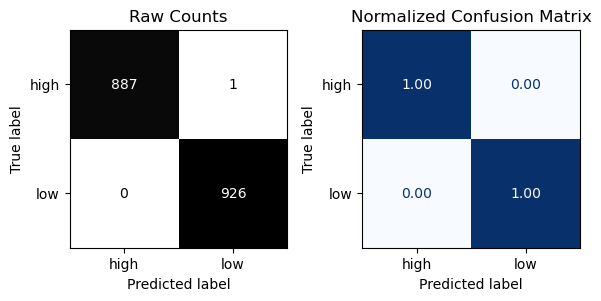


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.83      0.85      0.84       307
         low       0.84      0.82      0.83       298

    accuracy                           0.84       605
   macro avg       0.84      0.84      0.84       605
weighted avg       0.84      0.84      0.84       605



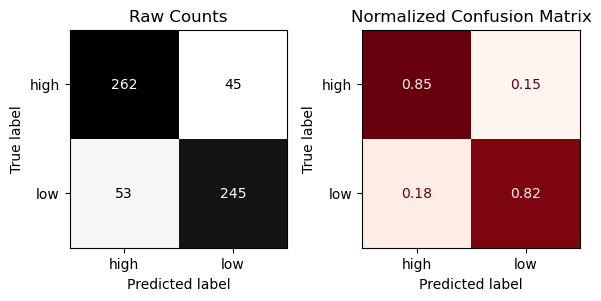

In [34]:
# evaluate model
fn.evaluate_classification(clf_pipe, X_train,y_train, X_test, y_test)

##### Observations:
- This model has an accuracy of .84
- There is not a large difference in accuracy between classes

#### GridSearch Text Vectorization

In [35]:
# Define params to try
param_grid_shared = {
    "vectorizer__max_df": [0.6, 0.7, 0.8],
    "vectorizer__min_df": [2,3,4],
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english'],
    "vectorizer__ngram_range": [(1, 1), (1, 2), (1,3)]
}

In [36]:
# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}

In [37]:
# Set up Pipeline to allow GridSearching
v_pipe = Pipeline([('vectorizer', CountVectorizer()),
                     ('clf',RandomForestClassifier(random_state=42))])

In [38]:
%%time
# Create grid search
grid_search = GridSearchCV(v_pipe, param_grid_shared, cv=2, scoring = 'accuracy', verbose=1, n_jobs=-1)

CPU times: total: 0 ns
Wall time: 0 ns


In [39]:
%%time
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 162 candidates, totalling 324 fits
CPU times: total: 4.52 s
Wall time: 3min 13s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'vectorizer__max_df': [0.6, 0.7, 0.8],
                         'vectorizer__max_features': [None, 1000, 2000],
                         'vectorizer__min_df': [2, 3, 4],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'vectorizer__stop_words': [None, 'english']},
             scoring='accuracy', verbose=1)

In [40]:
# what were the best params?
grid_search.best_params_

{'vectorizer__max_df': 0.6,
 'vectorizer__max_features': 1000,
 'vectorizer__min_df': 4,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__stop_words': 'english'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       888
         low       1.00      1.00      1.00       926

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814



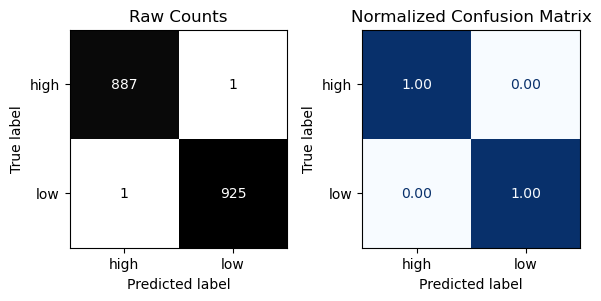


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.83      0.83      0.83       307
         low       0.82      0.82      0.82       298

    accuracy                           0.83       605
   macro avg       0.83      0.83      0.83       605
weighted avg       0.83      0.83      0.83       605



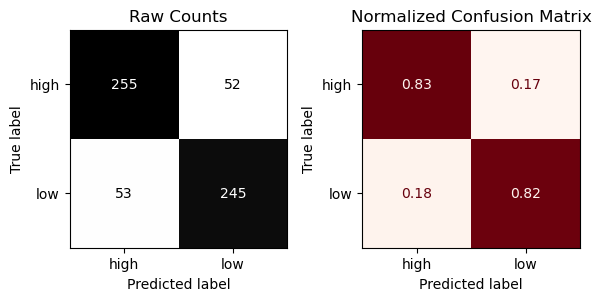

In [41]:
best_model = grid_search.best_estimator_

fn.evaluate_classification(best_model,X_train,y_train,X_test,y_test)

##### Observations:
- With best parameters the gridsearch an accuracy of .83

### Deep NLP

#### Prep / Train Dataset

In [42]:
# instantiate LabelEncoder
encoder = LabelEncoder()

In [43]:
# Fit and Transform the strings into integers
y = pd.Series(encoder.fit_transform(y))
y.value_counts()

1    1224
0    1195
dtype: int64

In [44]:
# Convert to Dataset object
ds = tf.data.Dataset.from_tensor_slices((X, y))
ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [45]:
# shuffle data once
ds = ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)

In [46]:
# Add a column to the dataframe that has the length of each paragraph
df['sequence_length'] = df['review'].map( lambda x: len(x.split(" ")))

In [47]:

df['sequence_length'].describe()

count    2419.000000
mean      225.767673
std       270.815728
min         1.000000
25%        62.000000
50%       143.000000
75%       286.500000
max      4017.000000
Name: sequence_length, dtype: float64

In [48]:
# maximum length = sequence length max
SEQUENCE_LENGTH = 4017

In [49]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )

In [50]:
# Calculate the number of samples for training and validation data
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

In [51]:
# Set the batch size
BATCH_SIZE =32

In [52]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)

# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)

# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [53]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

#### Creating Keras Text Vectorization Layer

In [54]:
# Create keras text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [55]:
# Fit/Adapt the text vectorization layer on the training texts.
sequence_vectorizer.adapt(ds_texts)

In [56]:
# Save the vocabulary size from the layer to use in your models' Embedding layer.
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()

In [57]:
# unique classes
classes = y.unique()
classes

array([0, 1])

#### RNN

In [58]:
# Function - using the model that performed best in core projects
def build_gru_model_bi_pool(text_vectorization_layer):

    gru_model_bi_pool = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                      output_dim=EMBED_DIM,
                      input_length=SEQUENCE_LENGTH)])

    # Add bidirectional component to GRU layer
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(64, return_sequences = True)))
    gru_model_bi_pool.add(layers.Dropout(.2))
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(32, return_sequences = True)))
    # Add a pooling layer *new
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())

    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation='softmax'))

    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool

In [61]:
EMBED_DIM = 100
#Build the model
model = build_gru_model_bi_pool(sequence_vectorizer)
# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=fn.get_callbacks(),
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 4017)             0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 4017, 100)         2492300   
                                                                 
 bidirectional_4 (Bidirectio  (None, 4017, 128)        63744     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 4017, 128)         0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 4017, 64)         31104     
 nal)                                                            
                                                      

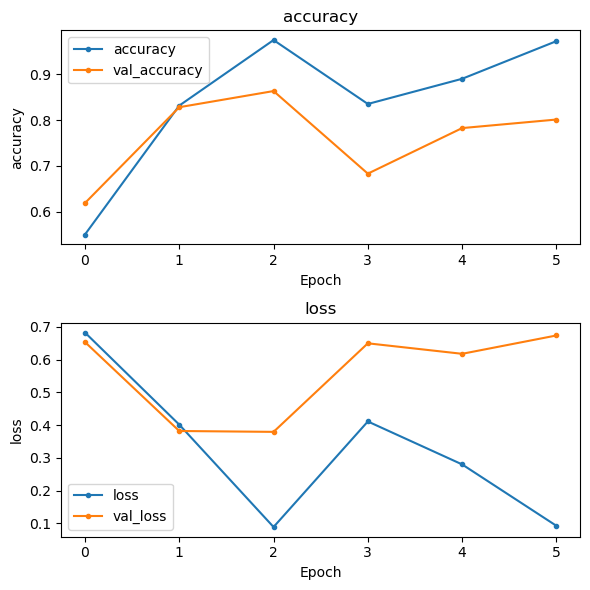


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       856
           1       0.92      0.98      0.95       837

    accuracy                           0.95      1693
   macro avg       0.95      0.95      0.95      1693
weighted avg       0.95      0.95      0.95      1693



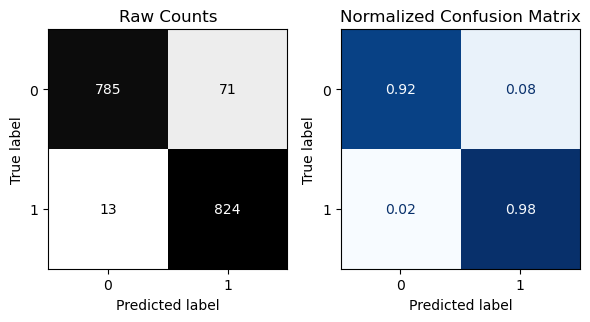


- Evaluating Training Data:
53/53 [==============================] - 55s 1s/step - loss: 0.1291 - accuracy: 0.9504
{'loss': 0.12910829484462738, 'accuracy': 0.9503839612007141}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       113
           1       0.85      0.85      0.85       130

    accuracy                           0.84       243
   macro avg       0.83      0.83      0.83       243
weighted avg       0.84      0.84      0.84       243



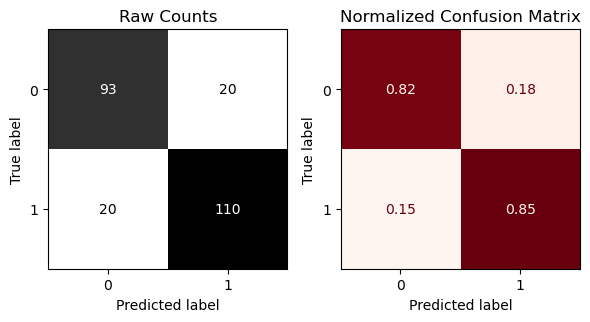


- Evaluating Test Data:
8/8 [==============================] - 7s 865ms/step - loss: 0.6870 - accuracy: 0.8354
{'loss': 0.686987578868866, 'accuracy': 0.8353909254074097}


In [62]:
# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds,
    X_test=test_ds, history=history);

##### Observations:
- Test data accuracy is .84